# Mixed-effects Models in `R`
As the final part of this lesson, we turn to the process of fitting LME models using `R`, as well as options around inference. These examples will all be fairly basic, but we will see more variety in the workshop this week. In addition, our focus will be on the `nlme` package to keep things simple. In reality, there are *two* `R` packages that are used frequently in practice: `nlme` and `lme4`. Both have their advantages and disadvantages, however, they are so similar that knowing one would easily allow you to use the other. For our purpose, the advantages of `lme4` are few at present and so we stick with `nlme` to reduce confusion.

## Fitting Mixed-effects Models with `nlme`
To fit an LME model using `nlme`, we use the `lme()` function, which has a syntax very similar to the `gls()` function. To understand how to use this, we will return to the long-formatted `anxiety` data from `datarium`.

In [1]:
library('datarium')
library('reshape2')

data('anxiety')
anxiety.grp3 <- anxiety[anxiety$group == 'grp3',]   # high exercise group
anxiety.grp3 <- subset(anxiety.grp3, select=-group) # remove group column

# repeats and number of subjects
t <- 3
n <- dim(anxiety.grp3)[1]

# reshape wide -> long
anxiety.long <- melt(anxiety.grp3,             # wide data frame
                     id.vars='id',             # what stays fixed?
                     variable.name="time",     # name for the new predictor
                     value.name="score")       # name for the new outcome

anxiety.long           <- anxiety.long[order(anxiety.long$id),] # order by ID
rownames(anxiety.long) <- seq(1,n*t)                            # fix row names
anxiety.long$id        <- as.factor(anxiety.long$id)            # convert ID to factor


In [2]:
head(anxiety.long)

  id time score
1 31   t1  14.6
2 31   t2  13.0
3 31   t3  11.7
4 32   t1  15.0
5 32   t2  13.0
6 32   t3  11.9

Our multilevel model for these data was specified earlier as

$$
\begin{alignat*}{2}
    y_{ij}    &= \mu_{i} + \alpha_{j} + \eta_{ij} &\quad\text{Level 1} \\
    \mu_{i}   &= \mu + \xi_{i}                    &\quad\text{Level 2} \\
\end{alignat*}
$$

which we can collapse to a single level by replacing $\mu_{i}$ with $\mu + \xi_{i}$ at Level 1. This gives the LME model

$$
y_{ij} = \mu + \alpha_{j} + \xi_{i} + \eta_{ij},
$$

where we have *two* fixed-effects of $\mu$ and $\alpha_{j}$, and *two* random-effects of $\xi_{i}$ and $\eta_{ij}$. To fit this model using `lme()` we use

In [3]:
library(nlme)
lme.mod <- lme(score ~ time, random= ~ 1|id, data=anxiety.long)

### Specifying Random-effects
As we can see above, the newest element of the `lme()` function is the `random=` argument. This uses a syntax very similar to what we have seen before when using `correlation=` and `weights=` with `gls()`. However, we need to think about this a little differently because we are not defining how we want a particular covariance structure to apply to the data. Instead, we are giving the *structure* of the random effects. 

We can think of this as simply a direct implementation of the LME equation above. We have

$$
y_{ij} = \overbrace{\mu + \alpha_{j}}^{\text{fixed}} + \overbrace{\xi_{i} + \eta_{ij}}^{\text{random}},
$$

so the *fixed-effects* part just appears in the model equation as `score ~ time`. The *random-effects* part consists of $\xi_{i} + \eta_{ij}$, but we do not need to specify $\eta_{ij}$ because that is the residual error term that is *always* included in a linear model. We know this already from `lm()` as we never have to ask for residuals, they are always there. So, the only thing that differentiates the model above from something we could fit with `lm()` is the term $\xi_{i}$. This is *precisely* what we specify using the `random=` argument. 

So what is $\xi_{i}$? Well, if we look at its index, it is a value that changes with *each subject*. It is therefore *constant* within a subject, but different between subjects. So how do we specify a value that is only constant *within* each subject? Well, we represent it as a constant using a `1` but make it *conditional* on the subject by using `|id`. So `1|id` can be read as *a constant per-subject*.


````{admonition} Multilevel Conceptualisation
:class: tip
Alternatively, we can built the `lme()` syntax from the multilevel conceptualisation. We can then think of the `random=` argument as describing elements of the model that we fit to each individual subject. We will use some pseudo-code below to get the idea across, just be aware that most of this is not valid `lme()` syntax (but the ideas are hopefully clear). As described earlier, when we have *no replications* within each level of the repeated measures, the best we can do with the data from *one* subject is fit a constant. So our model for one subject would be something like

`score[id == 1] ~ 1`

If we wanted this to work for *all* subjects, we would need to indicate that we want a *different* constant for each subject, which would give something like

`score ~ 1|id`

which we can read as "fit a constant *separately* for each level of `id`". 

Once we have multiple subjects, we have the option of estimating values by pooling data *across* subjects. So, with multiple subjects, we can add a fixed-effect of `time`. Using our current pseudo-code, this would give

`score ~ 1|id + time`.

However, this is *not* how `lme()` works. Instead, in order to clearly differentiate the random-effects from the fixed-effects, `lme()` requires that we move anything random out of the model equation and put it in a separate argument. So this gives the final *real* specification of

`lme(score ~ time, random= ~ 1|id)`
````

### Exploring the `lme()` Output
Before we get into the hairy topic of *inference*, let us explore the model we have just fit. We can print the estimates and other details by calling

In [4]:
print(lme.mod)

Linear mixed-effects model fit by REML
  Data: anxiety.long 
  Log-restricted-likelihood: -42.21856
  Fixed: score ~ time 
(Intercept)      timet2      timet3 
  17.013333   -2.000000   -3.453333 

Random effects:
 Formula: ~1 | id
        (Intercept)  Residual
StdDev:    1.344507 0.3034458

Number of Observations: 45
Number of Groups: 15 


Where we can see some fitting details, such as the estimation method (restricted maximum likelihood, or REML), the number of data points and the number of grouping structures we used (in this case, 15 subjects). We can also see the estimates of the *fixed-effects* as well as the variance terms calculated from the random effects (given as standard deviations).

The *fixed-effects* are interpreted in the same way as with `lm()`. Because `time` is categorical, `R` has converted it to a dummy variable. To make the model identifiable, `time1` has been dropped, so we have a dummy for `time2` and a dummy for `time3`. The `(Intercept)` parameter is therefore the mean value of `score` for `time1`, the `time2` parameter is the difference `time2 - time1`, and the `time3` parameter is the difference `time3 - time1`. This is exactly the same as we have seen previously with any linear model containing a categorical predictor variable. The *fixed-effects* therefore give us our predictions for the *marginal* means. In other words, when we *average across* the subjects. These are the model predictions for the population-level effects, in the same way that they would from a usual call to `lme()`.

The difference of course is that we now also have the *random-effects*. We can think of these as *error-terms*, either using an LME conceptualisation of a model with *multiple* errors, or using a multilevel conceptualisation of different errors at each *level* of the data hierarchy. Importantly, what the random-effects add to the model is not any change to the mean function, rather they create *additional variance terms*. The two random elements are

$$
\begin{alignat*}{1}
    \xi_{i}   &\sim \mathcal{N}\left(0,\sigma^{2}_{b}\right) \\
    \eta_{ij} &\sim \mathcal{N}\left(0,\sigma^{2}_{w}\right),
\end{alignat*}
$$

so estimating their expected value would be silly anyway, as it is 0 in both cases. Instead, we want to *use* the random effects to estimate $\sigma^{2}_{b}$ and $\sigma^{2}_{w}$. This is no different to the errors in a normal linear model, which are used to estimate $\sigma^{2}$. The difference now is that this overall variance has been *partitioned* into $\sigma^{2} = \sigma^{2}_{b} + \sigma^{2}_{w}$.

The estimated variance components are given in the output above under `Random effects:`. The `(Intercept)` term corresponds to $\xi_{i}$ and thus the estimate of $\sigma^{2}_{b} = 1.34^{2} = 1.80$. The `Residual` term corresponds to $\eta_{ij}$ and thus the estimate of $\sigma^{2}_{w} = 0.30^{2} = 0.09$. As expected, the within-subject variance is much smaller than the between-subject, as people tend to exhibit a degree of *internally consistency* but can differ wildly from others.

We can also have a look at the realised values of the random effects, using the `random.effects()` function. 

In [5]:
random.effects(lme.mod)

   (Intercept)
31  -2.0605689
32  -1.8639080
33  -2.0933457
34  -1.2083718
35  -0.8150501
36  -0.1922906
37   0.4632456
38   0.4304688
39   0.6271297
40   0.2010311
41   0.8565674
42   0.5943529
43   1.6104340
44   1.4465500
45   2.0037558

These are the estimated values of $\xi_{i}$ in this model and can be interpreted as *subject-specific* deflections from the population mean. For instance, $\xi_{1} = -2.06$. This means that irrespective of the value of `time`, subject 1 is predicted to sit *below* the population average by 2.06 points on the self-esteem scale. So, the predicted population mean for `time1` in this model is given by

$$
\hat{y}_{i1} = \hat{\mu} + \hat{\alpha}_{1} = \hat{\mu} = 17.01,
$$

irrespective of subject. However, the *conditional* mean for subject 1 is

$$
\hat{y}_{11} = \hat{\mu} + \hat{\alpha}_{1} + \xi_{1} = 17.01 - 2.06 = 14.95.
$$

So subject 1's personal offset is that they always score *lower* than the population average. The effect of `time` is therefore the same, they just fundamentally have lower self-esteem than average.

We can do this for any of the subjects, however, we do not really care about the realised values of $\xi_{i}$. These are a means to an end. Because they are considered *random*, their actual numeric value is not important. What *is* important is what they can tell us about the population they are drawn from. Because these are *deflections* and their expected value is 0, their mean is of little interest

In [6]:
mean(random.effects(lme.mod)[,1])

[1] 5.112548e-15

As we can see, this is effectively 0. Instead, what we want to know is how much the subject-specific deflections *vary*. Their *spread* tells us how much the subjects differ from each other and thus provides an estimate of $\sigma^{2}_{b}$. So, we can instead calculate

In [7]:
var(random.effects(lme.mod)[,1])

[1] 1.777518

The same is true of the residual errors, which are also mean 0 and can be used to estimate $\sigma^{2}_{w}$. 

We can look at both of these effects side-by-side by plotting their distributions. Remember, the theory states that

$$
\begin{alignat*}{1}
    \xi_{i}   &\sim \mathcal{N}\left(0,\sigma^{2}_{b}\right) \\
    \eta_{ij} &\sim \mathcal{N}\left(0,\sigma^{2}_{w}\right),
\end{alignat*}
$$

so we expect these to both approximate a normal distribution with mean 0 and some spread that is of interest to us. We plot both of these below as histograms a normal QQ-plots

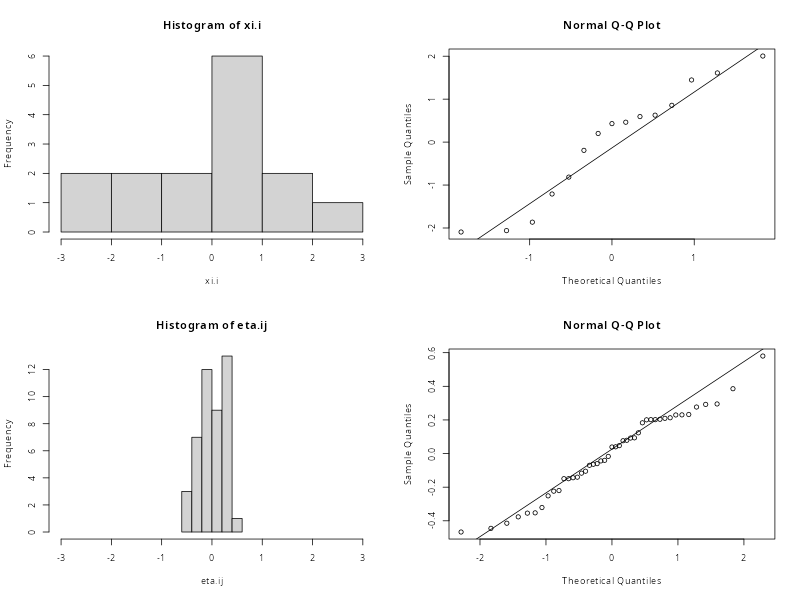

In [8]:
xi.i   <- random.effects(lme.mod)[,1]
eta.ij <- residuals(lme.mod)

par(mfrow=c(2,2))

# plot xi.i
hist(xi.i, xlim=c(-3,3))
qqnorm(xi.i)
qqline(xi.i)

# plot eta.ij
hist(eta.ij, xlim=c(-3,3))
qqnorm(eta.ij)
qqline(eta.ij)

Although the amount of data in this example makes the distributional form harder to verify, the key elements to notice here are that both distributions are centred on 0. So the expected values of both $\xi_{i}$ and $\eta_{ij}$ are 0. This is why the expected population effect is driven purely by the fixed-effects because, on average, the errors are 0. Secondly, the distribution of $\xi_{i}$ is *much wider* than the distribution of $\eta_{ij}$. This is because the distribution of $\xi_{i}$ reflects measurements from *different subjects* and the distribution of $\eta_{ij}$ reflects measurements from the *same subject*. 

We can also see the fundamental assumption behind treating `id` as a *random-effect*. When we do this, we conceptualise each level of `id` as a random draw from a larger population of subjects. We therefore assume some distributional form for the *subject* effects and estimate its variance. This is the distribution we see in the plot above. If we instead treated `id` as a *fixed-effect*, we assume that each of its levels represents some population-level constant that we want to estimate. There would be no distribution and no variance to estimate. We would be effectively saying that we are only interested in *these subjects* and no one else. We want to *precisely* know the mean of `id == '32'` and make comparisons and inference on `id == 32` compared to `id == 42` or `id == 44` or between any pairs of subjects. It would be like treating the levels of `id` in the same way as the levels of `time`. Although there may be cases where the subjects that you have are *special* and each one is *meaningful* on their own, this is not our usual aim when we collect a sample. So, for most experiments, the subjects *have* to be treated as a *random-effect* in order to make sense.

## Inference in Mixed-effects Models
As a final topic in this lesson, we return to the controversial subject of *inference*. As we know from previous lessons, assuming a more general form for the covariance structure $\boldsymbol{\Sigma}$ causes problems for the classical inferential framework. This is precisely because the distributions of the variance terms are no longer known. Traditionally, the variance has a scaled $\chi^{2}$ distribution, whose width is parameterised by the degrees of freedom. Without this, the null distribution of the tests statics are unknown and the whole concept of error degrees of freedom disappears from our testing framework. Recall as well that there were then 3 possible solutions to this problem:

- Assume we know $\boldsymbol{\Sigma}$ and carry on as usual
- Assume we know $\boldsymbol{\Sigma}$, but only because we have enough data and can use *asymptotic* results
- Compensate by calculating *effective* degrees of freedom

To begin with, we will briefly explore why all this remains relevant for mixed-effects models, by showing that a mixed-effects model is *equivalent* to a GLS model.

### The Implied Marginal Model
Although we have been working on the basis that a hierarchical/LME model does not require direct consideration of the covariance structure, the covariance structure *still exists*. Unlike GLS, this structure is *implied* rather than directly specified. Nonetheless, we saw earlier in our simulations that a given covariance structure will emerge as a property of the random effects. Because of this, we can think of an LME model as *implying* the following *marginal* model of the data

$$
\mathbf{y}_{i} \sim \mathcal{N}\left(\boldsymbol{\mu},\boldsymbol{\Sigma}_{i}\right),
$$

where we are assuming that $\mathbf{y}_{i}$ is the vector of repeated measurements from subject $i$, $\boldsymbol{\mu}$ is the vector of population means for the repeated measures and $\boldsymbol{\Sigma}_{i}$ is block $i$ from the full covariance structure. Remember, this is *marginal* because the mean structure is the average across *all subjects*, rather than *conditional* on this specific subject. Of importance, is that $\boldsymbol{\Sigma}_{i}$ can be formed *directly* from the random-effects. The way this is done requires more explanation of how LME models can be expressed using matrix notation and so is somewhat beyond our current score. Nevertheless, we can understand this from what we have seen previously where 

$$
\begin{alignat*}{1}
    \text{Var}\left(y_{ij}\right) &= \sigma^{2}_{b} + \sigma^{2}_{w} \\
    \text{Cov}\left(y_{ij},y_{ij^{\prime}}\right) &= \sigma^{2}_{b} \\
\end{alignat*}
$$

which implies a compound symmetric structure based on the random effects alone. The big-picture conclusion here is that an LME model *is the same as GLS*, but with a more sophisticated way of constructing the variance-covariance matrix using the random effects. This leads to some important conclusions:

1. The concept of *removing* the covariance structure and then estimating the fixed-effects remains the *same* under an LME model.
2. The inferential issues around GLS are *identical* for LME models.
3. The covariance structure is *more restricted* under LME models, because it is constrained by the random effects themselves. 

### The Marginal Covariance Structure
We can see all this visually using our model fit with `lme()`. In the code below, we use the `getVarCov()` function to again extract the marginal covariance matrix for a particular value of `id` and then visualise it.

         1        2        3
1 1.899778 1.807698 1.807698
2 1.807698 1.899778 1.807698
3 1.807698 1.807698 1.899778


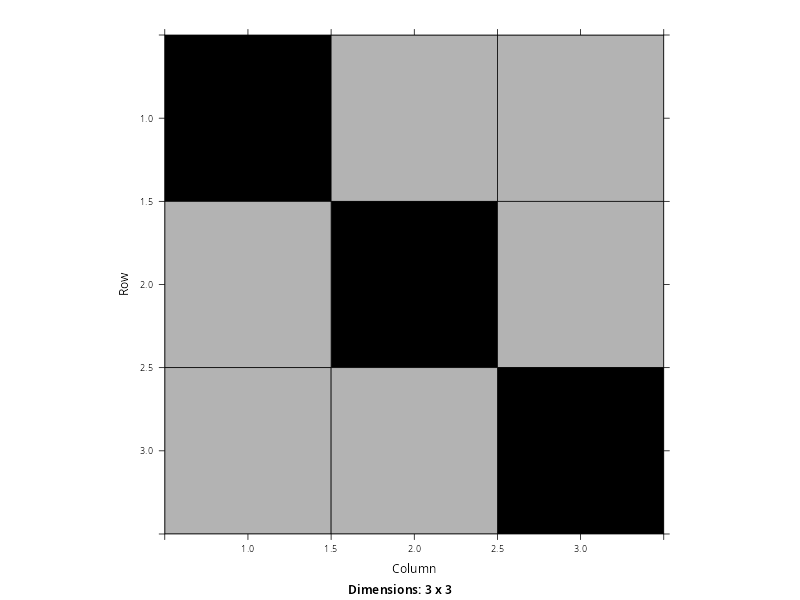

In [9]:
library('Matrix')

Sigma <- getVarCov(lme.mod, individual='31', type='marginal')
Sigma <- as.matrix(Sigma$`31`)

print(Sigma)
image(as(Sigma,'Matrix'))

As expected, this is *compound symmetric*, though this is now *implied* by the random-effects, rather than specified directly as we did with GLS. We can also use the function defined in the drop-down below to construct the *full* covariance matrix $\boldsymbol{\Sigma}$, using the details about the model structure in the model object returned by `lme()`.

In [10]:
library('Matrix')

fullVarCov <- function(fit) {
  grouping_var_name <- names(fit$groups)[1] # get grouping variable name (e.g "id")
  groups <- fit$data[[grouping_var_name]]   # use name to get grouping variable
  groups <- unique(as.character(groups))    # reduce grouping variable to unique values

  # for each unique grouping variable value, extract the covariance matrices
  blocks <- lapply(groups, function(gi) {
    S <- getVarCov(fit, individual = gi, type = "marginal")
    if (is.list(S)) {
      S <- S[[gi]]
    }
    as.matrix(S)
  })

  # put the covariance matrices into blocks
  V <- bdiag(blocks)
  V
}

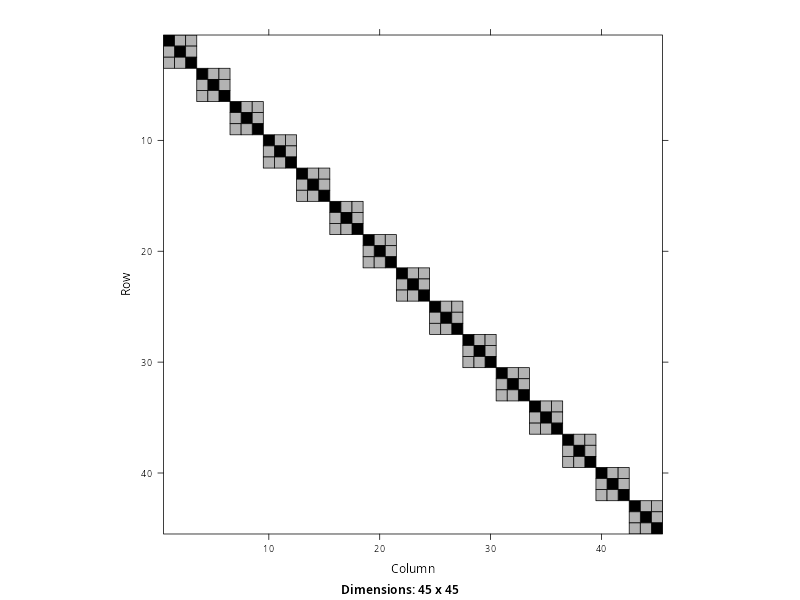

In [11]:
Big.Sigma <- fullVarCov(lme.mod)
image(Big.Sigma)

So we can see that this is indeed block-diagonal, with a compound symmetric structure per-subject and zeros everywhere else.

Although we are somewhat focusing on shared *disadvantages*, it is important to recognise that all the *advantages* of GLS are also still here. For instance, the correct error term for each test can be automatically generated from the covariance structure. So while a model may be no better than the repeated measures ANOVA in its covariance assumptions, it is infinitely *more practical* because we do not need to mess around manually assigning error terms to different tests (and worrying about getting this wrong). 

Additionally, the connection between the random-effects and the covariance structure implies that *more complex* random-effect specifications will lead to different covariance structures. Indeed, this is exactly the case. Where this is useful is when we have more complex data structures. Because the random-effects are a direct consequence of the structure of the data, the structure drives the covariance pattern. This means we do not have to reason about what pattern we want and whether we can express this to a function like `gls()`. Instead, we supply the data structure through the random-effects and the covariance is built for us, no matter its complexity. This is something that will become clearer when we start exploring more complex data structures *next week*.

### Inference Using `nlme`
Now, let us get back to the *practical* topic of inference using LME models in `R`. To begin, we can call `summary()` on the model object returned by `lme()`

In [12]:
summary(lme.mod)

Linear mixed-effects model fit by REML
  Data: anxiety.long 
       AIC      BIC    logLik
  94.43711 103.1255 -42.21856

Random effects:
 Formula: ~1 | id
        (Intercept)  Residual
StdDev:    1.344507 0.3034458

Fixed effects:  score ~ time 
                Value Std.Error DF   t-value p-value
(Intercept) 17.013333 0.3558818 28  47.80614       0
timet2      -2.000000 0.1108027 28 -18.05009       0
timet3      -3.453333 0.1108027 28 -31.16650       0
 Correlation: 
       (Intr) timet2
timet2 -0.156       
timet3 -0.156  0.500

Standardized Within-Group Residuals:
       Min         Q1        Med         Q3        Max 
-1.5378504 -0.4924282  0.1284212  0.6647537  1.9114200 

Number of Observations: 45
Number of Groups: 15 

As we can see, this returns an output very similar to what we have seen before from `lm()` and `gls()`. The main additional information we have compared to simply printing the model (as we did earlier) is the table of coefficients associated with the *fixed-effects*. However, notice two important details from the `gls()` output

1. Degrees of freedom and $t$-statistics are given, so this is *not* using and asymptotic approximation
2. The degrees of freedom are *not* based on assuming that $\boldsymbol{\Sigma}$ is known as they are *smaller* than those reported by `gls()`.

So, what is this output doing? It is using *effective* degrees of freedom to specify the tests, using the *structure* built-in to the LME model. Now, the method used is fairly basic and is given by a heuristic described more fully in [Pinheiro and Bates (2000, pg.91)](https://www.google.co.uk/books/edition/Mixed_Effects_Models_in_S_and_S_PLUS/y54QDUTmvDcC?hl=en&gbpv=1&dq=pinheiro+and+bates+2000&printsec=frontcover). Nevertheless, this tells us something important about LME models. Because the data structure is embedded in the model specification, we can more readily use this structure to make better approximations to the uncertainty around the variance terms. A GLS model has *no knowledge* of the structure. It just see a single covariance matrix of any structure that it can remove. So even though the heuristic used by `lme()` is a very basic approximation, it does agree with the classical specification of degrees of freedom in a repeated measures ANOVA. So, at the *very least* we are back in familiar territory.

## ANOVA Tables and Follow-up Tests

### Using `anova()`

In [15]:
print(anova(lme.mod, type='sequential'))
print(anova(lme.mod, type='marginal'))

            numDF denDF   F-value p-value
(Intercept)     1    28 1884.0239  <.0001
time            2    28  489.7321  <.0001
            numDF denDF   F-value p-value
(Intercept)     1    28 2285.4266  <.0001
time            2    28  489.7321  <.0001


What about Type II? Well, there's no direct equivalence built-in to the `anova()` function with an `lme()` model. You *could* do this manually with model comparisons (which will be covered in the workshop). However, for ease we probably just want to stick with the old faithful `Anova()` function from `car`.

### Using `Anova`

In [ ]:
library(car)
Anova(lme.mod)

````{admonition} Tests Using lme4
:class: tip, dropdown
So, even though we have not discussed `lme4`, this is one particular advantage of this package, because `lmerTest` allows us to use effective degrees of freedom consistently. However, this package does have some disadvantages that make it *less practical* for general use and so we will leave it to one side for now.
````

## Using `emmeans`

In [ ]:
library(emmeans)